# Geodésicas
Se buscará obtener las geodésicas y baricentros de la misma forma que en el ejemplo [Convolutional Wasserstein Barycenter](https://pythonot.github.io/auto_examples/barycenters/plot_convolutional_barycenter.html#sphx-glr-auto-examples-barycenters-plot-convolutional-barycenter-py), para luego obtener geodésicas implementadas en esta librería.

In [1]:
%cd D:\CodeProjects\Python\Bayesian-Learning-with-Wasserstein-Barycenters\

D:\CodeProjects\Python\Bayesian-Learning-with-Wasserstein-Barycenters


In [2]:
from bwb import config

# config.use_cpu()

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
from PIL import Image
# noinspection PyUnresolvedReferences
from PIL.Image import Resampling

# noinspection PyProtectedMember
import bwb.bregman
from bwb import logging
from bwb import transports as tpt
from bwb.distributions import *
from bwb.geodesics import *

_log = logging.get_logger("notebook")
# logging.set_level(logging.DEBUG)
_log

<Logger notebook (WARNING)>

In [4]:
from bwb.config import config
import torch
torch.cuda.is_available()

True

In [5]:
main_path = Path(".")

data_path = main_path / "data"
data_images_path = data_path / "images"
shapes_path = data_images_path / "shapes"
pot_shapes_path = data_images_path / "pot_shapes"

img_path = Path("img")

In [6]:
resolution = 128
size = (resolution, resolution)
resample = Resampling.LANCZOS

In [7]:
# # noinspection PyTypeChecker
# f1 = 1 - np.asarray(Image.open(pot_shapes_path / 'redcross.png').resize(size, resample))[:, :, 2] / 255
# # noinspection PyTypeChecker
# f2 = 1 - np.asarray(Image.open(pot_shapes_path / 'tooth.png').resize(size, resample))[:, :, 2] / 255
# # noinspection PyTypeChecker
# f3 = 1 - np.asarray(Image.open(pot_shapes_path / 'heart.png').resize(size, resample))[:, :, 2] / 255
# # noinspection PyTypeChecker
# f4 = 1 - np.asarray(Image.open(pot_shapes_path / 'duck.png').resize(size, resample))[:, :, 2] / 255

In [8]:
# noinspection PyTypeChecker
f1 = 1 - np.asarray(Image.open(shapes_path / 'shape1filled.png').resize(size, resample))[:, :, 2] / 255
# noinspection PyTypeChecker
f2 = 1 - np.asarray(Image.open(shapes_path / 'shape2filled.png').resize(size, resample))[:, :, 2] / 255
# noinspection PyTypeChecker
f3 = 1 - np.asarray(Image.open(shapes_path / 'shape3filled.png').resize(size, resample))[:, :, 2] / 255
# noinspection PyTypeChecker
f4 = 1 - np.asarray(Image.open(shapes_path / 'shape4filled.png').resize(size, resample))[:, :, 2] / 255

In [19]:
from bwb.config import config
conf = config

f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
f3 = f3 / np.sum(f3)
f4 = f4 / np.sum(f4)
A = np.array([f1, f2, f3, f4])
A = torch.tensor(A, dtype=conf.dtype, device=conf.device)

nb_images = 5

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = torch.tensor((1, 0, 0, 0), dtype=conf.dtype, device=conf.device)
v2 = torch.tensor((0, 1, 0, 0), dtype=conf.dtype, device=conf.device)
v3 = torch.tensor((0, 0, 1, 0), dtype=conf.dtype, device=conf.device)
v4 = torch.tensor((0, 0, 0, 1), dtype=conf.dtype, device=conf.device)

In [20]:
additional_info = f"resol-{resolution}-nb-images-{nb_images}"

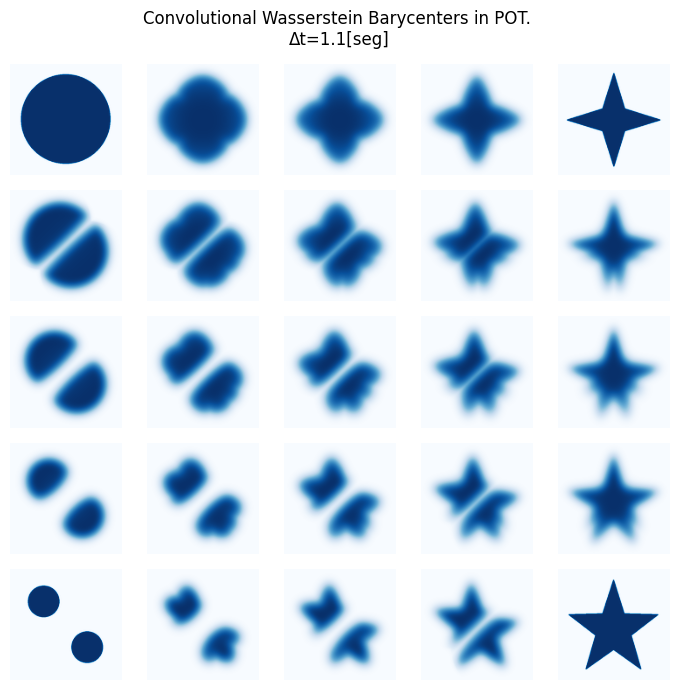

CPU times: total: 1.69 s
Wall time: 1.68 s


In [27]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
# regularization parameter
reg = 3e-3
entrop_sharp = False
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            axes[i, j].imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes[i, j].imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes[i, j].imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes[i, j].imshow(f4, cmap=cm)
        else:
            # call to barycenter computation
            bar, log = bwb.bregman.convolutional_barycenter2d(
                A, reg, weights,
                entrop_sharp=entrop_sharp,
                numItermax=1_000, stopThr=1e-8,
                # verbose=True,
                warn=False,
                log=True,
            )
            bar = bar.cpu()
            axes[i, j].imshow(bar, cmap=cm)
        axes[i, j].axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'Convolutional Wasserstein Barycenters in POT. {d_time}')

plt.tight_layout()
# plt.savefig(img_path / f"{additional_info}-entrop-sharp-{entrop_sharp}-conv-wasserstein-bar.png",
#             dpi=400)
plt.show()

In [12]:
A_ = A[0:2]
A_.shape

torch.Size([2, 128, 128])

In [32]:
torch.log(
    torch.tensor(config.eps)
)
config.eps

C:\Users\asoln\AppData\Local\Temp\ipykernel_8104\399251898.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(config.eps)


tensor(2.2204e-16)

dist_conv = -0.056556
dist_conv = -0.054078
dist_conv = -0.049885
dist_conv = -0.044020
dist_conv = -0.036578


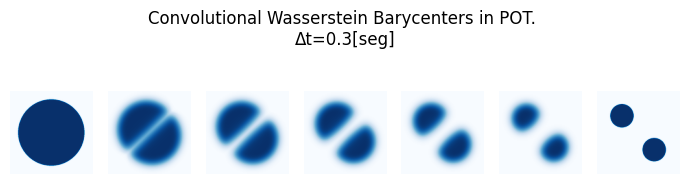

CPU times: total: 422 ms
Wall time: 420 ms


In [15]:
%%time
import time
from bwb.config import config
eps = config.eps

nb_images = 7
fig, axes = plt.subplots(1, nb_images, figsize=(7, 2))
cm = 'Blues'
# regularization parameter
reg = 4e-3
entrop_sharp = False
tic_ = time.time()
for i in range(nb_images):
    for j in range(1):
        ax = axes[i]
        tic = time.time()

        tx = float(i) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        weights = (1 - tx) * torch.tensor([1, 0], device=conf.device) + tx * torch.tensor([0, 1], device=conf.device)

        if i == 0 and j == 0:
            ax.imshow(f1, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            ax.imshow(f2, cmap=cm)
        else:
            # call to barycenter computation
            bar, log = bwb.bregman.convolutional_barycenter2d(
                A_, reg, weights,
                # entrop_sharp=entrop_sharp,
                numItermax=1_000, stopThr=1e-8,
                # verbose=True,
                warn=False,
                log=True,
            )
            V, W = log["V"], log["W"]
            dist_conv = reg * torch.sum(A_[0] * torch.log(W[0] + eps)
                                        + bar * torch.log(V[0] + eps))
            # dist_conv = reg * torch.sum(A_[0] * torch.log(V[0] + eps) + A_[1] * torch.log(W[0] + eps))
            print(f"{dist_conv = :.6f}")
            bar = bar.cpu()
            ax.imshow(bar, cmap=cm)
        ax.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'Convolutional Wasserstein Barycenters in POT. {d_time}')

plt.tight_layout()
# plt.savefig(img_path / f"{additional_info}-entrop-sharp-{entrop_sharp}-conv-wasserstein-bar.png",
#             dpi=400)
plt.show()

In [20]:
log

{'err': [tensor(9.2115e-05, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', dtype=torch.float64),
  tensor(nan, device='cuda:0', d

In [21]:
A_[0].type(torch.float)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [22]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn


# # Set these to whatever you want for your gaussian filter
# kernel_size = 15
# sigma = 1
# channels = 1

# # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
# x_cord = torch.arange(kernel_size)
# x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
# y_grid = x_grid.t()
# xy_grid = torch.stack([x_grid, y_grid], dim=-1)

# mean = (kernel_size - 1)/2.
# variance = sigma**2.

# # Calculate the 2-dimensional gaussian kernel which is
# # the product of two gaussian distributions for two different
# # variables (in this case called x and y)
# gaussian_kernel = torch.exp(
#     -torch.sum((xy_grid - mean)**2., dim=-1) / (2*variance)
# )

# # Make sure sum of values in gaussian kernel equals 1.
# gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

# # Reshape to 2d depthwise convolutional weight
# gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
# gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

# gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
#                             kernel_size=kernel_size, groups=channels, bias=False,
#                             padding=kernel_size//2)

# gaussian_filter.weight.data = gaussian_kernel
# gaussian_filter.weight.requires_grad = False

In [26]:
# gaussian_kernel, gaussian_kernel.shape

In [23]:
# img = A_[0].unsqueeze(0).unsqueeze(0)
# img: torch.Tensor = gaussian_filter(img.type(torch.float))
# img = img.squeeze()
# img = 255 * img / img.max()
# img.size()

In [23]:
from bwb.distributions.discrete_distribution import DistributionDraw
# DistributionDraw.from_array(img)

In [24]:
import math

sigma = 0.01
kernel_size = math.ceil(6 * sigma + 1)
kernel_size

2

In [25]:
img = A
img.shape

torch.Size([4, 128, 128])

kernel_size = 61, sigma = 10
tensor(1.0021, device='cuda:0', dtype=torch.float64)
img.size() = torch.Size([128, 128])
img.size() = torch.Size([128, 128])
img.size() = torch.Size([128, 128])
img.size() = torch.Size([128, 128])


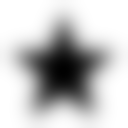

In [38]:
sigma = 10
kernel_size = min(math.ceil(6 * sigma + 1), 127*2)
if kernel_size % 2 == 0:
    kernel_size += 1
print(f"{kernel_size = }, {sigma = }")
# blurrer = torchvision.transforms.GaussianBlur(129, sigma=sigma)
blurrer = torchvision.transforms.GaussianBlur(kernel_size=kernel_size, sigma=sigma)

# img = A_[0].unsqueeze(0).unsqueeze(0)
img = A
img_ = blurrer(img)
# img = img.squeeze()
# print(f"{img.sum() = }")
img = img_[0]
print(img.sum())
img = 255 * img / img.max()
print(f"{img.size() = }")
DistributionDraw.from_array(img)

img = img_[1]
img = 255 * img / img.max()
print(f"{img.size() = }")
DistributionDraw.from_array(img)

img = img_[2]
img = 255 * img / img.max()
print(f"{img.size() = }")
DistributionDraw.from_array(img)

img = img_[3]
img = 255 * img / img.max()
print(f"{img.size() = }")
DistributionDraw.from_array(img)

In [42]:

from ot.backend import get_backend

reg = 3e-4

nx = get_backend(A)

dtype, device = nx.dtype_device(A)
    
# this is equivalent to blurring on horizontal then vertical directions
t = nx.linspace(0, 1, A.shape[1]).to(dtype=dtype, device=device)
[Y, X] = nx.meshgrid(t, t)
K1 = nx.exp(-(X - Y) ** 2 / reg)

t = nx.linspace(0, 1, A.shape[2]).to(dtype=dtype, device=device)
[Y, X] = nx.meshgrid(t, t)
K2 = nx.exp(-(X - Y) ** 2 / reg)

def convol_imgs(imgs):
    kx = nx.einsum("...ij,kjl->kil", K1, imgs)
    kxy = nx.einsum("...ij,klj->kli", K2, kx)
    return kxy

In [40]:
A[0].sum()

tensor(1., device='cuda:0', dtype=torch.float64)

tensor(15.2012, device='cuda:0', dtype=torch.float64)
img.size() = torch.Size([128, 128])


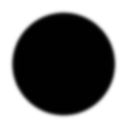

In [43]:

img = A
img_ = convol_imgs(img)
# img = img.squeeze()
# print(f"{img.sum() = }")
img = img_[0]
print(img.sum())
img = 255 * img / img.max()
print(f"{img.size() = }")
DistributionDraw.from_array(img)

# img = img_[1]
# img = 255 * img / img.max()
# print(f"{img.size() = }")
# DistributionDraw.from_array(img)

# img = img_[2]
# img = 255 * img / img.max()
# print(f"{img.size() = }")
# DistributionDraw.from_array(img)

# img = img_[3]
# img = 255 * img / img.max()
# print(f"{img.size() = }")
# DistributionDraw.from_array(img)

In [36]:
img

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0006, 0.0056, 0.0235,  ..., 0.0029, 0.0002, 0.0002],
        [0.0006, 0.0055, 0.0232,  ..., 0.0029, 0.0002, 0.0002],
        [0.0006, 0.0055, 0.0231,  ..., 0.0029, 0.0002, 0.0002]],
       device='cuda:0', dtype=torch.float64)

In [29]:
img_.shape

torch.Size([4, 128, 128])

# Utilizando geodésicas
Ahora que tenemos los resultados replicados del notebook de ejemplo, se procederá a replicar los resultados utilizando las clases creadas en esta librería, sólo calculando las geodésicas de par a par.

In [1]:
original_shape = f1.shape

dd1 = DistributionDraw.from_weights(f1.reshape(-1), original_shape)
dd2 = DistributionDraw.from_weights(f2.reshape(-1), original_shape)
dd3 = DistributionDraw.from_weights(f3.reshape(-1), original_shape)
dd4 = DistributionDraw.from_weights(f4.reshape(-1), original_shape)

NameError: name 'f1' is not defined

In [ ]:
weights = 
bwb.bregman.convolutional_barycenter2d(A, reg, weights,
                                       entrop_sharp=entrop_sharp, 
                                       numItermax=1_000,
                                       stopThr=1e-8,
#                                        verbose=True,
                                       warn=False),

Ahora se realizarán las matrices que serán graficadas

In [39]:
%%time
geodesic12 = McCannGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd1, dd_t=dd2)
geodesic13 = McCannGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd1, dd_t=dd3)
geodesic34 = McCannGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd3, dd_t=dd4)
geodesic24 = McCannGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd2, dd_t=dd4)

CPU times: total: 5.7 s
Wall time: 3.02 s


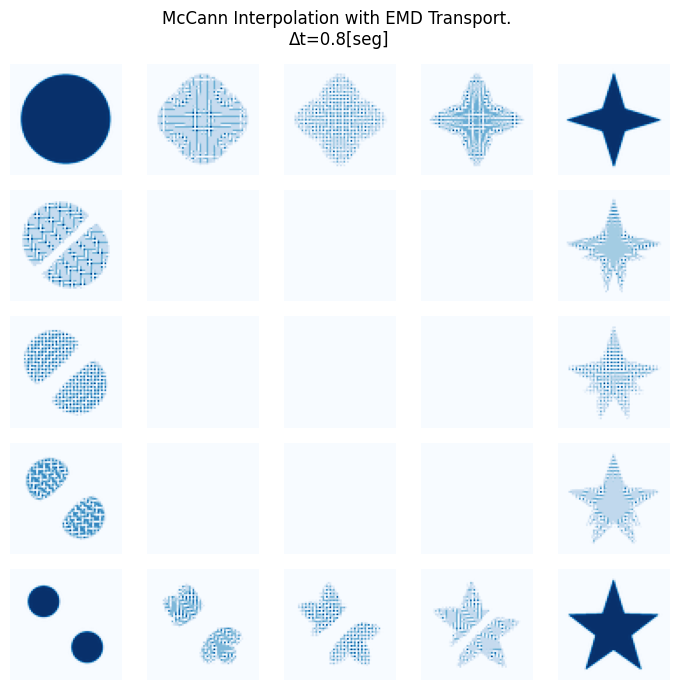

CPU times: total: 8.12 s
Wall time: 4.94 s


In [40]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'McCann Interpolation with EMD Transport. {d_time}')

plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-mccaan-interpolation-emd.png", dpi=800)
plt.show()

# Interpolación con la proyección baricéntrica

In [41]:
%%time
geodesic12 = BarycentricProjGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd1, dd_t=dd2)
geodesic13 = BarycentricProjGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd1, dd_t=dd3)
geodesic34 = BarycentricProjGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd3, dd_t=dd4)
geodesic24 = BarycentricProjGeodesic(tpt.EMDTransport(max_iter=250_000)).fit_wd(dd_s=dd2, dd_t=dd4)

CPU times: total: 5.44 s
Wall time: 2.95 s


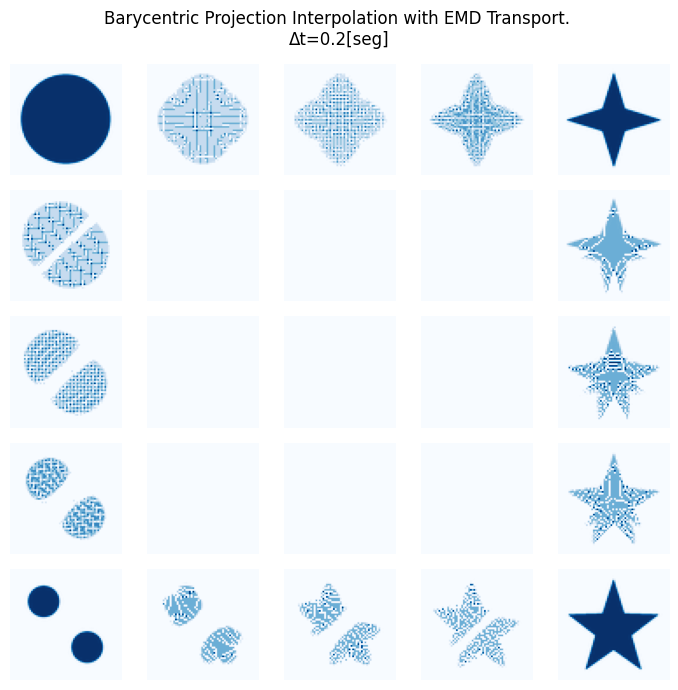

CPU times: total: 6.05 s
Wall time: 4.35 s


In [42]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"
plt.suptitle(f'Barycentric Projection Interpolation with EMD Transport. {d_time}')
plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-barycentric-proj-interpolation-emd.png", dpi=800)
plt.show()

# Interpolación con la proyección baricéntrica particionada

In [43]:
%%time
geodesic12 = PartitionedBarycentricProjGeodesic(
    tpt.EMDTransport(max_iter=250_000), alpha=0.1
).fit_wd(dd_s=dd1, dd_t=dd2)
geodesic13 = PartitionedBarycentricProjGeodesic(
    tpt.EMDTransport(max_iter=250_000), alpha=0.1
).fit_wd(dd_s=dd1, dd_t=dd3)
geodesic34 = PartitionedBarycentricProjGeodesic(
    tpt.EMDTransport(max_iter=250_000), alpha=0.1
).fit_wd(dd_s=dd3, dd_t=dd4)
geodesic24 = PartitionedBarycentricProjGeodesic(
    tpt.EMDTransport(max_iter=250_000), alpha=0.1
).fit_wd(dd_s=dd2, dd_t=dd4)

CPU times: total: 1min 31s
Wall time: 1min 27s


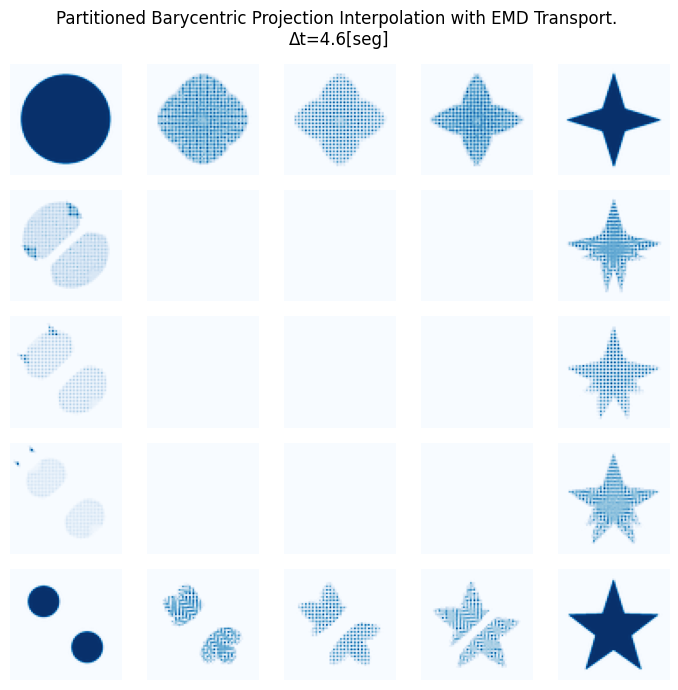

CPU times: total: 23 s
Wall time: 10.2 s


In [44]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"
plt.suptitle(f'Partitioned Barycentric Projection Interpolation with EMD Transport. {d_time}')
plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-barycentric-proj-interpolation-emd.png", dpi=800)
plt.show()

# Interpolación con Sinkhorn

In [45]:
%%time
kwargs = {
    "max_iter": 250_000,
    "reg_e": 1e-3,
    "norm": "max"
}

CPU times: total: 0 ns
Wall time: 0 ns


In [46]:
%%time
geodesic12 = McCannGeodesic(tpt.SinkhornTransport(**kwargs)).fit_wd(dd_s=dd1, dd_t=dd2)

CPU times: total: 422 ms
Wall time: 99 ms


In [47]:
interp_param = {}
# interp_param = {
#     "rtol": ,
#     "atol": 0,
# }

DistributionDraw(*geodesic12.interpolate(0.5, **interp_param), original_shape)

ValueError: Expected parameter probs (Tensor of shape (0,)) of distribution DistributionDraw(shape: (64, 64)) to satisfy the constraint Simplex(), but found invalid values:
tensor([])

In [ ]:
%%time
geodesic13 = McCannGeodesic(tpt.SinkhornTransport(**kwargs)).fit_wd(dd_s=dd1, dd_t=dd3)

In [ ]:
%%time
geodesic34 = McCannGeodesic(tpt.SinkhornTransport(**kwargs)).fit_wd(dd_s=dd3, dd_t=dd4)

In [ ]:
%%time
geodesic24 = McCannGeodesic(tpt.SinkhornTransport(**kwargs)).fit_wd(dd_s=dd2, dd_t=dd4)

In [ ]:
%%time
import time


fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"
plt.suptitle(f'McCann Interpolation with Sinkhorn Transport. {d_time}')
plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-mccaan-interpolation-sinkhorn.png", dpi=800)
plt.show()